[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ccc-frankfurt/aisel-hands-on/blob/main/notebooks/PedestrianDetector-IlluminInvMeasure.ipynb)

# AI Systems Engineering Lab (AISEL) -- Pedestrian Detector
based on the PHD Thesis of Michael Greiffenhagen: "Engineering, Statistical Modeling and Performance Characterization of a Real-Time Dual Camera Surveillance System" Erlangen 2001
### Module 1: Illumination invariant measure for each pixel

In [4]:
# general imports
import os
import sys
import numpy as np
import time

# import opencv, a open source computer vision framework
import cv2

#  import plotting routines
import matplotlib.pyplot as plt
plt.set_loglevel("error") # set debug level to error to suppress annoying warning in plotting routines
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
# activate notebook mode
%matplotlib notebook  

# import scipy distance measures
from scipy.spatial import distance


Get video with pedestrians walking around. File from epfl from https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/ and is scaled down to a lower resolution.

In [11]:
!wget https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/thraki/.wget-hsts'. HSTS will be disabled.
--2021-01-20 13:44:17--  https://github.com/ccc-frankfurt/aisel-hands-on/blob/main/data/epflpedestshort.avi?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi [following]
--2021-01-20 13:44:17--  https://github.com/ccc-frankfurt/aisel-hands-on/raw/main/data/epflpedestshort.avi
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi [following]
--2021-01-20 13:44:17--  https://raw.githubusercontent.com/ccc-frankfurt/aisel-hands-on/main/data/epflpedestshort.avi


In [12]:
# open video file within opencv

file ='./epflpedestshort.avi?raw=true'
cap = cv2.VideoCapture(file)

Inspect the first frame of the video and the R,G,B channels.
Get the first frame:

In [13]:
(status, frame) = cap.read()

Channels conversion for displaying only, matplotlib(the plotting library) follows RGB while opencv follows BGR schema

In [14]:
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

Plot the first frame and  the R,G,B channel intensity spectra:

<IPython.core.display.Javascript object>


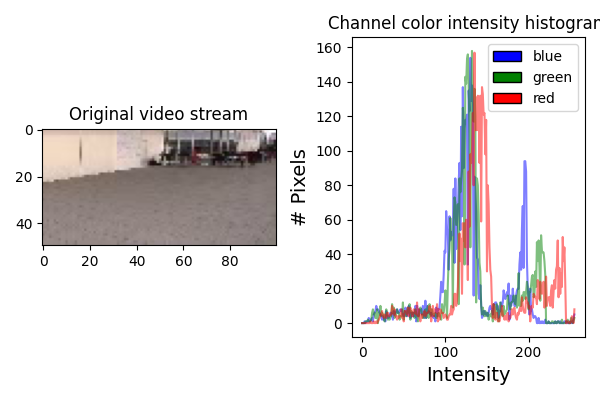

In [15]:
fig,ax = plt.subplots(1,2,figsize=(6, 4))

# set histogram titel and show image
ax[0].set_title("Original video stream")
ax[0].imshow(frame_rgb)

# set histogram titels and axis    
ax[1].set_title('Channel color intensity histogram')
ax[1].set_xlabel('Intensity',fontsize=14)
ax[1].set_ylabel('# Pixels',fontsize=14)

# get intensity histogram per channel and plot histogram
color = ('blue','green','red')
for i,clr in enumerate(color):
    histogram = cv2.calcHist([frame], [i], None, [256], [0, 256])
    ax[1].plot(histogram, color=clr,alpha=0.5, label=clr+'_channel')
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in color]
ax[1].legend(handles, color)
plt.tight_layout()

<p>Is the color channel intensity stable over time? </p>
Let us have a look at the video and perform the same operations as above.

In [ ]:
## to be run only locally for visual inspection and intuition -- does not display in google colab

# reload the video
cap = cv2.VideoCapture(file)

fig,ax = plt.subplots(1,2,figsize = (6, 4))

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    # display original frame 
    ax[0].set_title("Original video stream")
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax[0].imshow(frame_rgb)

    # set histogram titels and axis    
    ax[1].set_title('Channel intensity histogram')
    ax[1].set_xlabel('Intensity', fontsize = 14)
    ax[1].set_ylabel('# Pixels', fontsize = 14)

    # get intensity histogram per channel and plot histogram
    color = ('blue', 'green','red')
    for i,clr in enumerate(color):
        histogram = cv2.calcHist([frame], [i], None, [256], [0, 256])
        ax[1].plot(histogram, color=clr, alpha=0.5, label=clr+'_channel')
    
    
    # directives for plotting and layout
    handles = [Rectangle((0,0), 1, 1, color=c, ec="k") for c in color]
    ax[1].legend(handles, color)
    plt.tight_layout()
    fig.canvas.draw()
    #time.sleep(0.01)
    ax[0].clear()
    ax[1].clear()

    # directives for handling the opencv stream
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# closing the stream and releasing resources      
cap.release()
cv2.destroyAllWindows()


### A shadow invariant representation of the color data normalizes the color channels as follows:
$r = \frac{R}{R+G+B}$  and $g = \frac{G}{R+G+B}$
<p> This is a transformation of the kind $R^{3}$ -> $R^{2}$. Note that the information of the B channel is now encoded in the r and g channel.</p>

Define the transformation within a function:

In [18]:
def get_normalised_channels(img):
    """Extract BGR channel of an image and return normalised r and g channels."""
    b,g,r = cv2.split(img)
    # Intensities are stored as int8, upcast for mathematical operations
    b = b.astype('int16');g = g.astype('int16');r = r.astype('int16')
    # Calculate sum over all channels
    rgb = np.add(r,np.add(b,g))
    # Calculate normalised channels
    r_norm = np.divide(r,rgb)
    g_norm = np.divide(g,rgb)
    return r_norm,g_norm

Let us have a look at the histogram on a frame

In [19]:
cap = cv2.VideoCapture(file)
(status, frame) = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

<IPython.core.display.Javascript object>


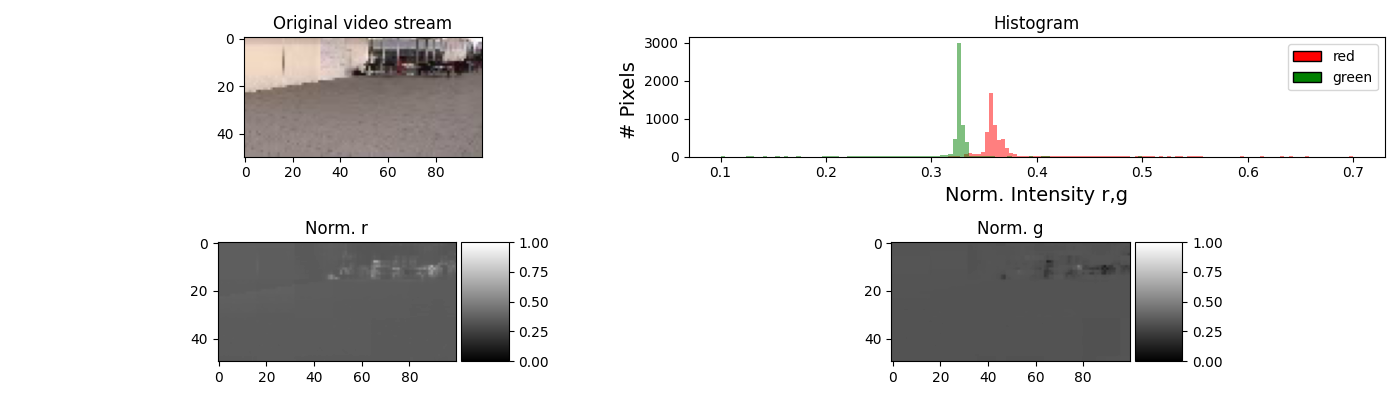

In [20]:
fig,ax = plt.subplots(2,2,figsize=(14, 4))

# plot the original histogram
ax[0][0].imshow(frame_rgb)

# get normalised channels
r_norm, g_norm  = get_normalised_channels(frame)   

# plot normalised channels
ax1=ax[1][0].imshow(r_norm,cmap='gray',vmin=0, vmax=1)

# plot normalised channels
ax2=ax[1][1].imshow(g_norm,cmap='gray',vmin=0, vmax=1)

#plot a histogram of the normalised channels per image
col_normed=['red','green']
for i,col_norm in enumerate([r_norm,g_norm]):
    ax[0][1].hist(col_norm.flatten(),alpha=0.5,bins=100,color=col_normed[i])
    
######################################
# directives for plotting and layout -- not so interesting to you
ax[0][0].set_title("Original video stream")
ax[1][0].set_title('Norm. r')
ax[1][1].set_title('Norm. g')
ax[0][1].set_title('Histogram')
ax[0][1].set_xlabel('Norm. Intensity r,g',fontsize=14)
ax[0][1].set_ylabel('# Pixels ',fontsize=14)
divider = make_axes_locatable(ax[1][0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax1,cax=cax)
divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax2,cax=cax)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in col_normed]
ax[0][1].legend(handles, col_normed)
plt.tight_layout()

Now let us come back the video

<IPython.core.display.Javascript object>


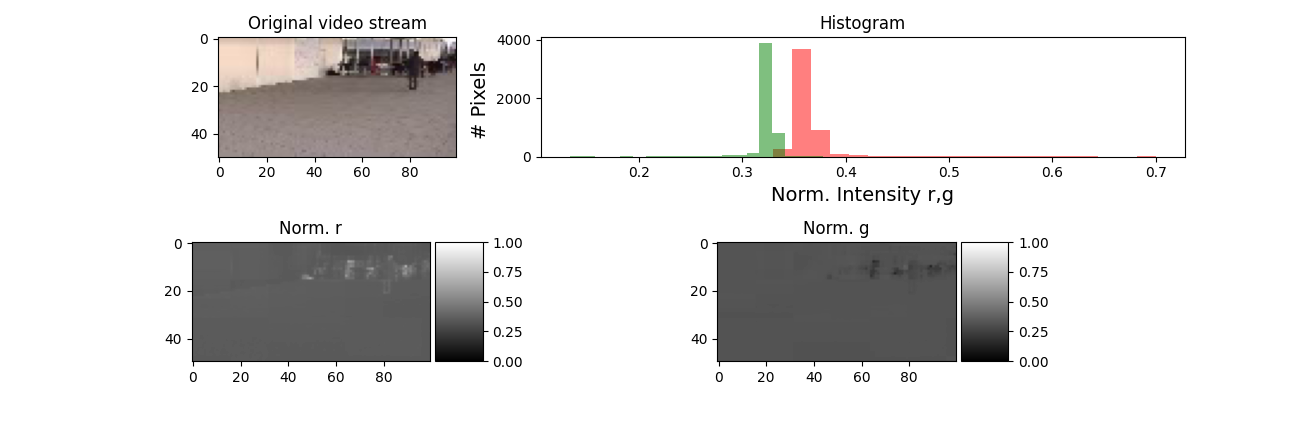

In [ ]:
## to be run only locally for visual inspection and intuition -- does not display in google colab

fig,ax = plt.subplots(2,2,figsize=(12, 4))

divider = make_axes_locatable(ax[1][0])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax1,cax=cax)
divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(ax2,cax=cax)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in col_normed]
ax[0][1].legend(handles, col_normed)

cap = cv2.VideoCapture(file)

success = True
while success:
    # get frame
    (success, frame) = cap.read()
    if not success :
        continue
    
    # display original frame 
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax[0][0].imshow(frame_rgb)    
    # get normalised channels
    r_norm, g_norm  = get_normalised_channels(frame)    
   # plot normalised channels
    ax1=ax[1][0].imshow(r_norm,cmap='gray',vmin=0, vmax=1)

    # plot normalised channels
    ax2=ax[1][1].imshow(g_norm,cmap='gray',vmin=0, vmax=1)

    #plot a histogram of the normalised channels per image
    col_normed=['red','green']
    for i,col_norm in enumerate([r_norm,g_norm]):
        ax[0][1].hist(col_norm.flatten(),alpha=0.5,bins=20,color=col_normed[i])

    
    #####################################
    ax[0][0].set_title("Original video stream")
    ax[1][0].set_title('Norm. r')
    ax[1][1].set_title('Norm. g')
    ax[0][1].set_title('Histogram')
    ax[0][1].set_xlabel('Norm. Intensity r,g',fontsize=14)
    ax[0][1].set_ylabel('# Pixels ',fontsize=14)
    plt.tight_layout()
    fig.canvas.draw()
    
    ax[0][0].clear();ax[0][1].clear();ax[1][0].clear();ax[1][1].clear()
    

cap.release()
cv2.destroyAllWindows()

What is this transformation for? Why and under which conditions are the statements true?